In [1]:
'''
File name: preprocessing.ipynb
Authors: Yasmin El Euch, Aliénor Bénédicte G Hamoir, Clara Rossignol, Guillaume David E. Ryelandt
Date created: 04/11/2022
Date last modified: 11/11/2022
Python version: 3.8.8
'''

'\nFile name: preprocessing.ipynb\nAuthors: Yasmin El Euch, Aliénor Bénédicte G Hamoir, Clara Rossignol, Guillaume David E. Ryelandt\nDate created: 04/11/2022\nDate last modified: 11/11/2022\nPython version: 3.8.8\n'

# Gender gap in the film industry
Our goal here is to analyze the evolution of sexism and women discrimination in the film industry with time. 
With the #MeToo movement in 2017 (it first started in 2007 but made less noise), we expect a positive evolution in the gender gap, in the movie industry and else where. Did the MeToo movement really impact the situation? We could compare the data before 2007, between 2007 and 2016, and after 2017 to see if the different steps of the movement made things change.

In order to evaluate the gender gap in the film industry, we will have a look at 3 different axis.
First, we'll check the financial aspect, trying to correlate the numbers to discrimination (while being careful to confounders). We'll have a look at the box office revenues and we will try to find the salaries of actors.
Secondly, we will analyze the evolution of the types of roles attributed to women, to see if there is an improvement in this sense to diminish the gender gap. To do so, we will look at textual data with NLP libraires (i.e. we will treat the summaries) through topic detection, sentiment analysis, feminine pronouns occurences, ... to extract information on the type of roles and the types of representation of women in movies. The importance of the role will also be evaluated. Tropes and stereotypes will be analyzed too, from the adequate dataset, and put into relation with the summaries.

## Table of contents

0. [General Information](#GI)\
        A. [Folder structure](#Folder)\
        B. [Imports](#Imports)\
        C. [Paths](#Paths)
</br> 
1. [Step 1: Data scraping, pre-processing and dataset construction](#Step-1)\
        A. 
</br> 

---
## General Information <a id="GI"> </a> 

### Folder structure <a id="Folder"> </a>

***Files and directories to make this notebook run successfully:***

- **data/**
    - *character.metadata.tsv*
    - *movie.metadata.tsv*
    - *name.clusters.txt*
    - *plot_summaries.txt*
    - *tvtropes.clusters.txt*
- *preprocessing.ipynb*

Directories are in **bold** and files are in *italic*.


### Imports <a id="Imports"> </a>

***Libraries used:***
- python=3.8.12
- pandas
- datetime
- numpy
- matplotlib
- regex

In [1]:
#Imports used in this notebook
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re


### Paths <a id="Paths"> </a>

Required to adapt those path to local file organization

In [2]:
### PATHs for dataset:

PATH_DATA = 'data/'
PATH_MOVIE_METADATA = PATH_DATA+'movie.metadata.tsv'
PATH_PLOT_SUMMARY = PATH_DATA+'plot_summaries.txt'
PATH_CHARACTER_METADATA = PATH_DATA+'character.metadata.tsv'

---
## **Step 1: Data scraping, pre-processing and dataset construction** <a id="Step-1"> </a>

In [98]:
print("Reading in movie data")

#Read in movie metadata, plot summaries, and character metadata.
movie_headers = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name','Movie release date','Movie box office revenue',
                 'Movie runtime','Movie languages','Movie countries','Movie genres']
plot_headers = ['Wikipedia movie ID','Plot Summary']
character_headers = ['Wikipedia movie ID', 'Freebase movie ID','Movie release date','Character name','Actor date of birth',
                     'Actor gender','Actor height','Actor ethnicity','Actor name','Actor age at movie release',
                     'Freebase character/actor map ID','Freebase character ID','Freebase actor ID']
tvtropes_headers = ['char_trope', 'char_name', 'movie_name', 'freebase_char_actor_map_id', 'actor_name']

movie_metadata = pd.read_csv(PATH_MOVIE_METADATA,sep='\t',header=None,names=movie_headers,index_col=0)
plot_summaries = pd.read_csv(PATH_PLOT_SUMMARY,sep='\t',index_col=0,names=plot_headers)
character_metadata = pd.read_csv(PATH_CHARACTER_METADATA,sep='\t',header=None,names=character_headers,index_col='Wikipedia movie ID')
tvtropes_clusters = pd.read_csv(PATH_DATA + 'tvtropes.clusters.txt', sep='\t', header=None, names=['char_types', 'instances'])



Reading in movie data


In [4]:
movie_metadata.head()

,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [5]:
movie_metadata.index.is_unique

True

In [6]:
print('Sum of NaN in each feature of the movie.metadata dataset: ')
movie_metadata.isna().sum(axis = 0)

Sum of NaN in each feature of the movie.metadata dataset: 


Freebase movie ID               0
Movie name                      0
Movie release date           6902
Movie box office revenue    73340
Movie runtime               20450
Movie languages                 0
Movie countries                 0
Movie genres                    0
dtype: int64

In [7]:
movie_metadata.isna().any()

Freebase movie ID           False
Movie name                  False
Movie release date           True
Movie box office revenue     True
Movie runtime                True
Movie languages             False
Movie countries             False
Movie genres                False
dtype: bool

In [8]:
n_movie = len(movie_metadata)
print('Percentage of missing entries in the movie.metadata dataset:\n', 100*movie_metadata[['Movie release date', 'Movie box office revenue', 'Movie runtime']].isna().sum() / n_movie)

Percentage of missing entries in the movie.metadata dataset:
 Movie release date           8.443743
Movie box office revenue    89.722416
Movie runtime               25.018045
dtype: float64


We are missing a lot of the data on the movie box office revenue. Maybe we should try and find those missing informations in another dataset as this could be helpful in our analysis.

In [9]:
plot_summaries.head()

,Plot Summary
Wikipedia movie ID,
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,..."
595909,Seventh-day Adventist Church pastor Michael Ch...


In [10]:
plot_summaries.index.is_unique

True

In [11]:
print('Sum of NaN in each feature : ')
plot_summaries.isna().sum(axis = 0)

Sum of NaN in each feature : 


Plot Summary    0
dtype: int64

In [12]:
character_metadata.head()

,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
Wikipedia movie ID,,,,,,,,,,,,
975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [13]:
character_metadata.isna().any()

Freebase movie ID                  False
Movie release date                  True
Character name                      True
Actor date of birth                 True
Actor gender                        True
Actor height                        True
Actor ethnicity                     True
Actor name                          True
Actor age at movie release          True
Freebase character/actor map ID    False
Freebase character ID               True
Freebase actor ID                   True
dtype: bool

In [14]:
print('Sum of NaN in each feature of the character.metadata dataset: ')
character_metadata.isna().sum(axis = 0)

Sum of NaN in each feature of the character.metadata dataset: 


Freebase movie ID                       0
Movie release date                   9995
Character name                     257875
Actor date of birth                106145
Actor gender                        45609
Actor height                       295845
Actor ethnicity                    344611
Actor name                           1228
Actor age at movie release         158113
Freebase character/actor map ID         0
Freebase character ID              257865
Freebase actor ID                     815
dtype: int64

In [15]:
n_char = len(character_metadata)
print('Percentage of missing entries in the character.metadata dataset:\n', 100*character_metadata[['Freebase movie ID', 'Movie release date', 'Character name',
                                                                                   'Actor date of birth', 'Actor gender', 'Actor height', 'Actor ethnicity',
                                                                                   'Actor name', 'Actor age at movie release', 'Freebase character ID',
                                                                                   'Freebase actor ID']].isna().sum() / n_char)

Percentage of missing entries in the character.metadata dataset:
 Freebase movie ID              0.000000
Movie release date             2.217814
Character name                57.220488
Actor date of birth           23.552763
Actor gender                  10.120288
Actor height                  65.645740
Actor ethnicity               76.466542
Actor name                     0.272484
Actor age at movie release    35.084064
Freebase character ID         57.218269
Freebase actor ID              0.180842
dtype: float64


We are missing a lot of data on actor's and actresses' ethnicities and their heights. This should not affect our analysis a we did not plan on using these features initially.

In [16]:
print("Movies with biggest box office revenues:")
movie_metadata.sort_values('Movie box office revenue', ascending = False).head()

Movies with biggest box office revenues:


,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,
4273140,/m/0bth54,Avatar,2009-12-10,2.782275e+09,178.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
52371,/m/0dr_4,Titanic,1997-11-01,2.185372e+09,194.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America""}","{""/m/0fx2s"": ""Tragedy"", ""/m/04xvh5"": ""Costume ..."
22114132,/m/062zm5h,The Avengers,2012-04-11,1.511758e+09,137.0,"{""/m/06b_j"": ""Russian Language"", ""/m/02h40lc"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ..."
31941988,/m/0gvsynb,Harry Potter and the Deathly Hallows – Part 2,2011-07-07,1.328111e+09,130.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/07s9rl0"": ""Drama"", ""/m/02n4kr"": ""Mystery""..."
25001260,/m/0872p_c,Transformers: Dark of the Moon,2011-06-23,1.123747e+09,157.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mt0"": ""Alien Film"", ""/m/06n90"": ""Scie..."


In [17]:
n_movie = len(movie_metadata)
n_char = len(character_metadata)
print('Number of rows in the movie.metadata dataset : %d' %n_movie)
print('Number of rows in the character.metadata dataset : %d' %n_char)

Number of rows in the movie.metadata dataset : 81741
Number of rows in the character.metadata dataset : 450669


In [18]:
print("What is needed to be processed in the character metadata dataset:")
print("Rows with actor age at movie release under or equal to 0: %d" %len(character_metadata[character_metadata['Actor age at movie release']<=0]))
print("Rows with actor height under or equal to 0: %d" %len(character_metadata[character_metadata['Actor height']<=0]))
print("Rows with movie runtime under or equal to 0: %d" %len(movie_metadata[movie_metadata['Movie runtime']<=0]))

What is needed to be processed in the character metadata dataset:
Rows with actor age at movie release under or equal to 0: 433
Rows with actor height under or equal to 0: 0
Rows with movie runtime under or equal to 0: 1


In [19]:
#Looking for duplicates in our datasets
for f in movie_metadata.columns:
    dupl = movie_metadata[f].duplicated().sum()
    print("{} has {} duplicated rows".format(f, dupl))

Freebase movie ID has 0 duplicated rows
Movie name has 6263 duplicated rows
Movie release date has 61351 duplicated rows
Movie box office revenue has 74378 duplicated rows
Movie runtime has 81143 duplicated rows
Movie languages has 79924 duplicated rows
Movie countries has 79617 duplicated rows
Movie genres has 57924 duplicated rows


In [20]:
movie_metadata[movie_metadata["Movie name"]=="Hunting Season"]

,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,
29666067,/m/0fphzrf,Hunting Season,1010-12-02,12160978.0,140.0,"{""/m/02hwyss"": ""Turkish Language"", ""/m/02h40lc...","{""/m/01znc_"": ""Turkey""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/02n4kr"": ""My..."


In [21]:
movie_metadata.dtypes

Freebase movie ID            object
Movie name                   object
Movie release date           object
Movie box office revenue    float64
Movie runtime               float64
Movie languages              object
Movie countries              object
Movie genres                 object
dtype: object

We can see that the release date of this movie is wrong. 1010-12-02 should be 2010-12-02.

In [22]:
movie_metadata.loc[movie_metadata['Movie release date'] == '1010-12-02','Movie release date'] = '2010-12-02'

In [23]:
movie_metadata[movie_metadata["Movie name"]=="Hunting Season"]

,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,
29666067,/m/0fphzrf,Hunting Season,2010-12-02,12160978.0,140.0,"{""/m/02hwyss"": ""Turkish Language"", ""/m/02h40lc...","{""/m/01znc_"": ""Turkey""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/02n4kr"": ""My..."


In [24]:
'''
movie_metadata['Movie release date'] = pd.to_datetime(movie_metadata['Movie release date'],format='%Y-%m-%d').dt.year
character_metadata['Movie release date'] = pd.to_datetime(character_metadata['Movie release date'],format='%Y-%m-%d').dt.year
character_metadata['Actor date of birth'] = pd.to_datetime(character_metadata['Actor date of birth'],format='%Y-%m-%d').dt.year
'''

"\nmovie_metadata['Movie release date'] = pd.to_datetime(movie_metadata['Movie release date'],format='%Y-%m-%d').dt.year\ncharacter_metadata['Movie release date'] = pd.to_datetime(character_metadata['Movie release date'],format='%Y-%m-%d').dt.year\ncharacter_metadata['Actor date of birth'] = pd.to_datetime(character_metadata['Actor date of birth'],format='%Y-%m-%d').dt.year\n"

Read the tv tropes dataset and separate the tropes into a list of tropes for each movie.


In [25]:


#read attr and split into 4 columns the instances

tvtropes_clusters['char'] = tvtropes_clusters['instances'].str.split(',').str[0]
tvtropes_clusters['movie'] = tvtropes_clusters['instances'].str.split(',').str[1]
tvtropes_clusters['id'] = tvtropes_clusters['instances'].str.split(',').str[2]
tvtropes_clusters['actor'] = tvtropes_clusters['instances'].str.split(',').str[3]
tvtropes_clusters = tvtropes_clusters.drop(columns=['instances'])

#only keep the relevant text

tvtropes_clusters['char'] = tvtropes_clusters['char'].str[10:]
tvtropes_clusters['char'] = tvtropes_clusters['char'].str[:-1]


tvtropes_clusters['movie'] = tvtropes_clusters['movie'].str[11:]
tvtropes_clusters['movie'] = tvtropes_clusters['movie'].str[:-1]

tvtropes_clusters['id'] = tvtropes_clusters['id'].str[8:]
tvtropes_clusters['id'] = tvtropes_clusters['id'].str[:-1]

tvtropes_clusters['actor'] = tvtropes_clusters['actor'].str[11:]
tvtropes_clusters['actor'] = tvtropes_clusters['actor'].str[:-2]
tvtropes_clusters.head(10)


,char_types,char,movie,id,actor
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader
5,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Kingdom of the Crystal S...,/m/0jzx78,Harrison Ford
6,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Raiders of the Lost Ark,/m/0k294p,Harrison Ford
7,adventurer_archaeologist,Indiana Jones,Indiana Jones and the Temple of Doom,/m/0jzx9b,Harrison Ford
8,adventurer_archaeologist,Evelyn Carnahan-O'Connell,The Mummy,/m/0k5yzc,Rachel Weisz
9,arrogant_kungfu_guy,Han,Enter the Dragon,/m/02vd8hn,Shih Kien


# Step 2: first analysis of women representation in the film industry - number of actresses vs. actors in the character metadata dataset

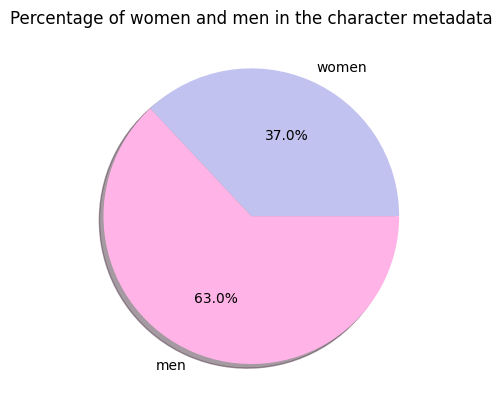

In [26]:
fem_act = character_metadata[character_metadata['Actor gender'] == 'F']
masc_act = character_metadata[character_metadata['Actor gender'] == 'M']
plt.pie(np.array([fem_act['Actor name'].nunique(),masc_act['Actor name'].nunique()]),labels=['women','men'],colors = ['#c2c2f0','#ffb3e6'],autopct='%1.1f%%',shadow=True)
plt.title('Percentage of women and men in the character metadata')
plt.show()

In [27]:
#replace NaN values with 0
character_metadata_clean = character_metadata.fillna(0)
movie_metadata_clean = movie_metadata.fillna(0)

In [28]:

#new dataframe with movies after 2007 after converting the release date to datetime some dates are only year so we need to add the month and day

movie_metadata_clean['Movie release date'] = pd.to_datetime(movie_metadata_clean['Movie release date'],errors='coerce')
movie_metadata_clean = movie_metadata_clean[movie_metadata_clean['Movie release date'] > datetime(2007,1,1)]
movie_metadata_clean.head()

,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,
21926710,/m/05p45cv,White on Rice,2009-01-01,0.0,82.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""..."
20604092,/m/0523t_1,Anbu Thozhi,2007-08-17,0.0,0.0,"{""/m/07c9s"": ""Tamil Language""}","{""/m/03rk0"": ""India""}","{""/m/02l7c8"": ""Romance Film""}"
29772142,/m/0fq260_,Karayilekku Oru Kadal Dooram,2010-12-31,0.0,110.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/07s9rl0"": ""Drama""}"
26623942,/m/0bh9fbk,Kausthubham,2010-03-19,0.0,0.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/07s9rl0"": ""Drama""}"
32445576,/m/0gyv1h1,Vinayaka Geleyara Balaga,2011-07-15,0.0,0.0,{},{},{}


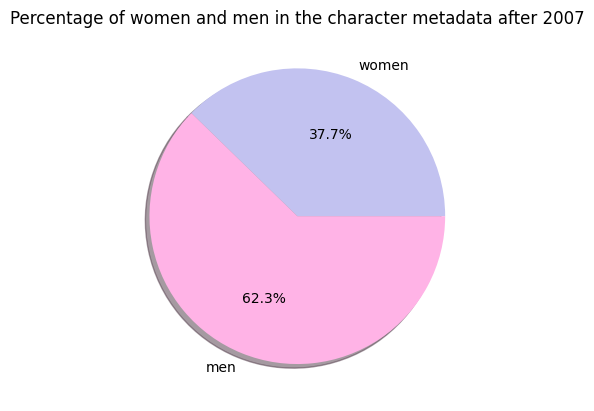

In [29]:
#only keep characters with 'wikipedia movie ID' in movie_metadata_clean after 2007
character_metadata_clean = character_metadata_clean[character_metadata_clean.index.isin(movie_metadata_clean.index)]
#number of female actors compared to male actors for movies after 2007 plotted in a pie chart
fem_act = character_metadata_clean[character_metadata_clean['Actor gender'] == 'F']
masc_act = character_metadata_clean[character_metadata_clean['Actor gender'] == 'M']
plt.pie(np.array([fem_act['Actor name'].nunique(),masc_act['Actor name'].nunique()]),labels=['women','men'],colors = ['#c2c2f0','#ffb3e6'],autopct='%1.1f%%',shadow=True)
plt.title('Percentage of women and men in the character metadata after 2007')
plt.show()

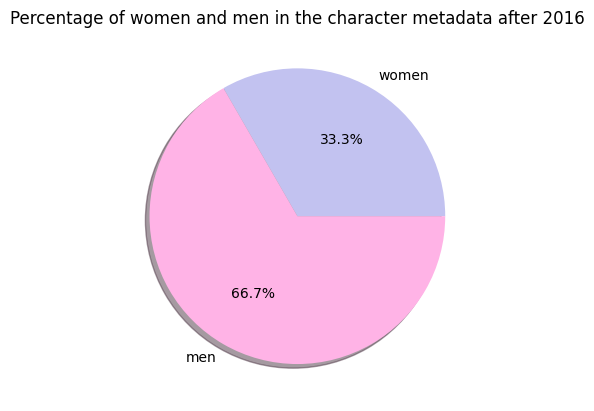

In [30]:
#new dataframe with movies after 2016 
movie_metadata_clean = movie_metadata_clean[movie_metadata_clean['Movie release date'] > datetime(2016,1,1)]
#only keep characters with 'wikipedia movie ID' in movie_metadata_clean after 2016
character_metadata_clean = character_metadata_clean[character_metadata_clean.index.isin(movie_metadata_clean.index)]
#number of female actors compared to male actors for movies after 2016 plotted in a pie chart
fem_act = character_metadata_clean[character_metadata_clean['Actor gender'] == 'F']
masc_act = character_metadata_clean[character_metadata_clean['Actor gender'] == 'M']
plt.pie(np.array([fem_act['Actor name'].nunique(),masc_act['Actor name'].nunique()]),labels=['women','men'],colors = ['#c2c2f0','#ffb3e6'],autopct='%1.1f%%',shadow=True)
plt.title('Percentage of women and men in the character metadata after 2016')
plt.show()

In [31]:
"""
Don't use character_metadata_clean as it has been defined lastly as with the movies released after 2016 only (there are only 2)
"""

#analysing plot summaries to find main character is the one whose name is mentioned the most
#we will use the first 1000 characters of the plot summary to find the main character

#function to find the main character in a plot summary
def find_main_character(plot_summary):
    #create a list of all the characters in the plot summary
    characters = character_metadata_clean[character_metadata_clean.index == plot_summary.name]['Character name'].to_list()
    #create a list of the number of times each character is mentioned in the plot summary
    character_count = [plot_summary['Plot Summary'][:2000].count(character) for character in characters]
    #return the character with the highest number of mentions
    return characters[np.argmax(character_count)]   

#apply the function to the plot summaries
#plot_summaries['Main character'] = plot_summaries.apply(find_main_character(plot_summaries),axis=1)
#plot_summaries.head()

Our analysis could be done here: there is discrimination in the film industry as women are under-representated. They only stand for 1/3 of characters in the studied movies in our datasets. But it is not as simple as that... how does this gender gap evolves in time, and particularly, how is it linked to the type of roles women are attributed to?

# Step 3: Discrimination through salaries, box office revenues, etc.

In [32]:
#Find movies without box office revenue and filter them out
no_rev = movie_metadata.loc[movie_metadata['Movie box office revenue'].isnull()].index
movie_metadata_filt = movie_metadata.drop(no_rev)

In [33]:
movie_metadata.shape[0]

81741

In [34]:
movie_metadata_filt.shape[0]

8401

We only have 8401 movies where we have their box office revenue.

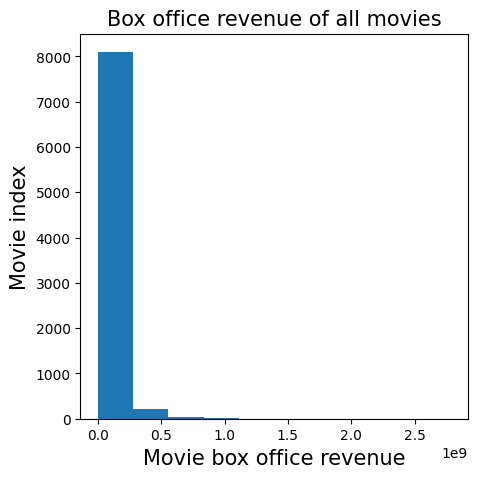

In [35]:
#Histogram of box office revenue of movies

plt.figure(figsize=(5,5), dpi = 100)
plt.xlabel('Movie box office revenue', fontsize = 15)
plt.ylabel('Movie index', fontsize=15)
plt.title('Box office revenue of all movies', fontsize=15)

plt.hist(movie_metadata_filt['Movie box office revenue'])

plt.show()

#plot en log pour mieux voir?

In [36]:
print("Movies with biggest box office revenues:")
movie_metadata.sort_values('Movie box office revenue', ascending = False).head()

Movies with biggest box office revenues:


,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,
4273140,/m/0bth54,Avatar,2009-12-10,2.782275e+09,178.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
52371,/m/0dr_4,Titanic,1997-11-01,2.185372e+09,194.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America""}","{""/m/0fx2s"": ""Tragedy"", ""/m/04xvh5"": ""Costume ..."
22114132,/m/062zm5h,The Avengers,2012-04-11,1.511758e+09,137.0,"{""/m/06b_j"": ""Russian Language"", ""/m/02h40lc"":...","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ..."
31941988,/m/0gvsynb,Harry Potter and the Deathly Hallows – Part 2,2011-07-07,1.328111e+09,130.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/07s9rl0"": ""Drama"", ""/m/02n4kr"": ""Mystery""..."
25001260,/m/0872p_c,Transformers: Dark of the Moon,2011-06-23,1.123747e+09,157.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mt0"": ""Alien Film"", ""/m/06n90"": ""Scie..."


In [37]:
movie_metadata_filt["Movie release date"] = pd.to_datetime(movie_metadata_filt["Movie release date"],errors='coerce')

In [38]:
movie_metadata_filt

,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
Wikipedia movie ID,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ..."
171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa..."
77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""..."
612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
...,...,...,...,...,...,...,...,...
54540,/m/0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""..."
7761830,/m/0kvgqb,Spaced Invaders,1990-01-01,15369573.0,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mt0"": ""Alien Film"", ""/m/06n90"": ""Scie..."
1918494,/m/0660qx,State and Main,2000-08-26,6944471.0,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/0gf28"": ""Parody"", ""/m/09n5t_"": ""Americana..."


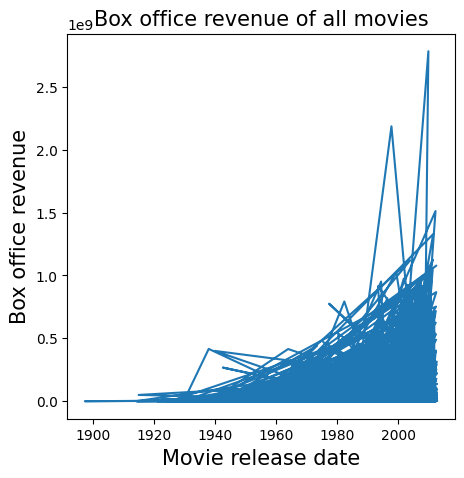

In [39]:
#No real use just to see

plt.figure(figsize=(5,5), dpi = 100)
plt.xlabel('Movie release date', fontsize = 15)
plt.ylabel('Box office revenue', fontsize=15)
plt.title('Box office revenue of all movies', fontsize=15)

plt.plot(movie_metadata_filt["Movie release date"],movie_metadata_filt['Movie box office revenue'])

plt.show()

In [40]:
character_metadata

,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
Wikipedia movie ID,,,,,,,,,,,,
975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...
913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44


In [41]:
character_dropna = character_metadata.dropna()

In [42]:
'''
character_dropna['Actor gender'] = pd.get_dummies(character_dropna['Actor gender'])
character_dropna.head()
'''

"\ncharacter_dropna['Actor gender'] = pd.get_dummies(character_dropna['Actor gender'])\ncharacter_dropna.head()\n"

# Step 4: Discrimination through types of roles attribution and its evolution in time


# Step 4.1: Summaries treatment


In [43]:
# feminine pronouns occurence in summaries

In [44]:
def indicator_variable(dic,x,s):
    '''
    Returns indicator variable which equals to 1 if the corresponding headline uses 
    the corresponding type of pronoun and 0 otherwise.
    :param dic: dictionary
    :param x: string
    :param s: string
    :return: indicator variable
    '''
    return int(bool(set(dic[s]) & set(x.lower().split(" "))))

In [45]:
feature_wordsets = dict([
    # https://en.wikipedia.org/wiki/English_personal_pronouns
    ('fem_pronoun', ['she','her','hers','herself', 
                               "she'll", "she's", 'shes']),
    ('masc_pronoun', ['he','him','his','himself',
                               "he'd", "he's", 'hes'])
])

plot_summaries["fem_pronoun"] = plot_summaries["Plot Summary"].apply(lambda x : indicator_variable(feature_wordsets,x,'fem_pronoun'))
plot_summaries["masc_pronoun"] = plot_summaries["Plot Summary"].apply(lambda x : indicator_variable(feature_wordsets,x,'masc_pronoun'))


In [46]:
plot_summaries


,Plot Summary,fem_pronoun,masc_pronoun
Wikipedia movie ID,,,
23890098,"Shlykov, a hard-working taxi driver and Lyosha...",0,0
31186339,The nation of Panem consists of a wealthy Capi...,1,1
20663735,Poovalli Induchoodan is sentenced for six yea...,1,1
2231378,"The Lemon Drop Kid , a New York City swindler,...",1,1
595909,Seventh-day Adventist Church pastor Michael Ch...,1,1
...,...,...,...
34808485,"The story is about Reema , a young Muslim scho...",1,0
1096473,"In 1928 Hollywood, director Leo Andreyev look...",1,1
35102018,American Luthier focuses on Randy Parsons’ tra...,0,1


In [47]:
length_summaries = len(plot_summaries)

In [48]:
print('The number of summaries with feminine pronouns occurence:', sum(plot_summaries["fem_pronoun"]))
print('The percentage of summaries with feminine pronouns occurence:', 100*(sum(plot_summaries["fem_pronoun"]))/ length_summaries, "%")

The number of summaries with feminine pronouns occurence: 25181
The percentage of summaries with feminine pronouns occurence: 59.5253291728719 %


In [49]:
print('The number of summaries with masculine pronouns occurence:', sum(plot_summaries["masc_pronoun"]))
print('The percentage of summaries with masculine pronouns occurence:', 100*(sum(plot_summaries["masc_pronoun"]))/ length_summaries, "%")

The number of summaries with masculine pronouns occurence: 35197
The percentage of summaries with masculine pronouns occurence: 83.2021369642815 %


We observe that there is more than 23\% difference between the occurence of feminine and masculine pronouns in the given summaries.


We can check if the pronouns occurence changes through time. 

In [50]:
# add a release date column to the plot_summaries dataset

summaries_with_date = movie_metadata_filt.join(plot_summaries) #there were more summaries than given movies
summaries_with_date = summaries_with_date.dropna()
summaries_with_date["Movie release date"] = pd.to_datetime(summaries_with_date["Movie release date"],errors='coerce')
summaries_with_date = summaries_with_date.sort_values(by="Movie release date")

summaries_with_date 

,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Plot Summary,fem_pronoun,masc_pronoun
Wikipedia movie ID,,,,,,,,,,,
3333,/m/0151l,The Birth of a Nation,1915-01-01,50000000.0,190.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi...",The film follows two juxtaposed families: the...,1.0,1.0
4499436,/m/0c5ppr,Way Down East,1920-01-01,4500000.0,147.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi...","The rich, typified by the handsome man-about-t...",1.0,1.0
1346905,/m/04vl27,The Kid,1921-01-01,2500000.0,60.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra...",An unwed woman leaves a charity hospital carr...,1.0,1.0
21135479,/m/05b_29y,Little Lord Fauntleroy,1921-01-01,900000.0,112.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra...",Cedric Errol is a poor American boy who finds ...,0.0,1.0
2137591,/m/06pkq3,The Four Horsemen of the Apocalypse,1921-03-06,4500000.0,134.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi...",The 1921 film is a fictional story inspired b...,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
33316658,/m/0gydg4g,House at the End of the Street,2012-09-21,31096918.0,101.0,"{""/m/02h40lc"": ""English Language""}",{},"{""/m/03npn"": ""Horror""}",Newly divorced Sarah and her daughter Elissa ...,1.0,1.0
27383563,/m/0by1wkq,Looper,2012-09-28,136513833.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ...","By 2044, the United States has suffered econom...",1.0,1.0
35316287,/m/0gh9fjz,Here Comes the Boom,2012-10-12,30610000.0,105.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02kdv5l"": ""Action"", ""/m/01z4y"": ""Comedy""}",Former collegiate wrestler Scott Voss is a 42...,0.0,1.0


In [99]:
plot_summaries
#merge character metadata with plot summaries

plot_summaries = plot_summaries.join(character_metadata, on='Wikipedia movie ID')
plot_summaries=plot_summaries.dropna()
plot_summaries

,Plot Summary,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
Wikipedia movie ID,,,,,,,,,,,,,
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Gale Hawthorne,1990-01-13,M,1.910,/m/0bbz66j,Liam Hemsworth,22.0,/m/0gw7kv7,/m/0ds96_p,/m/04yd0fh
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Caesar Flickerman,1960-11-11,M,1.721,/m/0xnvg,Stanley Tucci,51.0,/m/0gw7kw1,/m/0gwc3bn,/m/02bj6k
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,President Snow,1935-07-17,M,1.930,/m/07bch9,Donald Sutherland,76.0,/m/0gwc391,/m/0dsbx11,/m/0ywqc
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Cinna,1964-05-26,M,1.740,/m/041rx,Lenny Kravitz,47.0,/m/0gw7kvx,/m/0gwc39n,/m/0161sp
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Claudius Templesmith,1966-09-07,M,1.650,/m/0d7wh,Toby Jones,45.0,/m/0j5lh7t,/m/0j5lh7x,/m/071ywj
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8605430,The story develops around the evolution of Tit...,/m/0279p_0,2002,Titli,1979-12-03,F,1.550,/m/0dryh9k,Konkona Sen Sharma,22.0,/m/02tb7xb,/m/04hqnqj,/m/09w3dt
4913923,"In Northern Norway during the 1860s, a little ...",/m/0cty8f,2002-03-08,Leo Zhukovsky,1964-02-16,M,1.830,/m/02w7gg,Christopher Eccleston,38.0,/m/0jzpw0,/m/0h0v5q0,/m/02cbs0
4913923,"In Northern Norway during the 1860s, a little ...",/m/0cty8f,2002-03-08,Niels,1965-11-22,M,1.830,/m/0268_k,Mads Mikkelsen,36.0,/m/04d89tq,/m/0h39rc3,/m/076svb


In [100]:
#create a function that counts the occurence of a word in a string
def count_word(word, string):
    return string.count(word)

#count the number of times each character is mentioned in the plot summary
plot_summaries['Character occurence'] = plot_summaries.apply(lambda x: count_word(x['Character name'], x['Plot Summary']), axis=1)



,Plot Summary,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID,Character occurence
Wikipedia movie ID,,,,,,,,,,,,,,


In [106]:
plot_summaries

,Plot Summary,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID,Character occurence
Wikipedia movie ID,,,,,,,,,,,,,,
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Gale Hawthorne,1990-01-13,M,1.910,/m/0bbz66j,Liam Hemsworth,22.0,/m/0gw7kv7,/m/0ds96_p,/m/04yd0fh,0
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Caesar Flickerman,1960-11-11,M,1.721,/m/0xnvg,Stanley Tucci,51.0,/m/0gw7kw1,/m/0gwc3bn,/m/02bj6k,1
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,President Snow,1935-07-17,M,1.930,/m/07bch9,Donald Sutherland,76.0,/m/0gwc391,/m/0dsbx11,/m/0ywqc,2
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Cinna,1964-05-26,M,1.740,/m/041rx,Lenny Kravitz,47.0,/m/0gw7kvx,/m/0gwc39n,/m/0161sp,0
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Claudius Templesmith,1966-09-07,M,1.650,/m/0d7wh,Toby Jones,45.0,/m/0j5lh7t,/m/0j5lh7x,/m/071ywj,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8605430,The story develops around the evolution of Tit...,/m/0279p_0,2002,Titli,1979-12-03,F,1.550,/m/0dryh9k,Konkona Sen Sharma,22.0,/m/02tb7xb,/m/04hqnqj,/m/09w3dt,12
4913923,"In Northern Norway during the 1860s, a little ...",/m/0cty8f,2002-03-08,Leo Zhukovsky,1964-02-16,M,1.830,/m/02w7gg,Christopher Eccleston,38.0,/m/0jzpw0,/m/0h0v5q0,/m/02cbs0,0
4913923,"In Northern Norway during the 1860s, a little ...",/m/0cty8f,2002-03-08,Niels,1965-11-22,M,1.830,/m/0268_k,Mads Mikkelsen,36.0,/m/04d89tq,/m/0h39rc3,/m/076svb,7


In [123]:
#create dataframe with the highest character occurence for each Freebase movie ID and the corresponding character name and gender

character_occurence = plot_summaries.groupby('Freebase movie ID')['Character occurence'].max().reset_index()
character_occurence = character_occurence.merge(plot_summaries[['Freebase movie ID', 'Character name', 'Character occurence']], on=['Freebase movie ID', 'Character occurence'], how='left')
character_occurence = character_occurence.drop_duplicates(subset='Freebase movie ID', keep='first')
character_occurence = character_occurence.drop('Character occurence', axis=1)
character_occurence

#add character name and gender to character_occurence
character_occurence = character_occurence.merge(character_metadata[['Freebase movie ID', 'Character name', 'Actor gender']], on=['Freebase movie ID', 'Character name'], how='left')

character_occurence

,Freebase movie ID,Character name,Actor gender
0,/m/011wtv,Agatha,F
1,/m/011x_4,Phil Connors,M
2,/m/011xg5,David,M
3,/m/011xrr,Lord John Whorfin,M
4,/m/011ycb,Albert Freedman,M
...,...,...,...
15079,/m/0yyg4,Anderson,M
15080,/m/0yyn5,Jack Trainer,M
15081,/m/0yyts,Hoke Colburn,M
15082,/m/0yzbg,Todd Anderson,M


Freebase movie ID    5691
Character name       5691
Actor gender         5691
dtype: int64


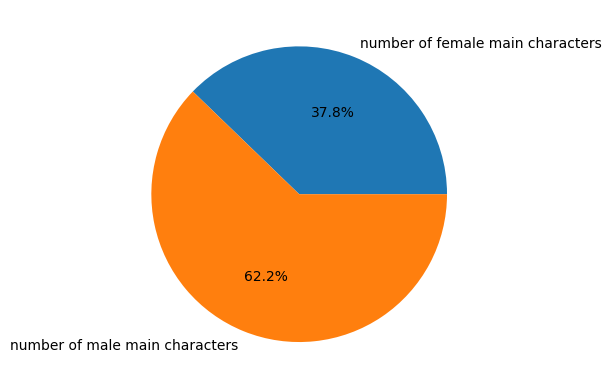

In [128]:

x=character_occurence[character_occurence['Actor gender'] == 'F'].count()
print(x)
y=character_occurence[character_occurence['Actor gender'] == 'M'].count()
#plot x and y in a pie chart
plt.pie([x[0] , y[0]], labels=['number of female main characters', 'number of male main characters'], autopct='%1.1f%%')
plt.show()




In [89]:
# find the occurence of the plot_summaries['Character name'] in the text plot_summaries['Plot Summary']

#function that returns the number of times a character is mentioned in a plot summary
def character_occurence(character, plot_summary):
    #create a list of all the characters in the plot summary
    characters = plot_summary[plot_summary.index == plot_summary.name]['Character name'].to_list()
    print(characters)
    #create a list of the number of times each character is mentioned in the plot summary
    character_count = [plot_summary['Plot Summary'][:2000].count(character) for character in characters]
    
    #return the character with the highest number of mentions
    return np.sum(character_count)

#apply the function to the plot summaries
plot_summaries['Character occurence'] = plot_summaries.apply(lambda x: character_occurence(x['Character name'],x),axis=1)

#only keep the plot summaries where the character is mentioned at least once
plot_summaries = plot_summaries[plot_summaries['Character occurence'] > 0]

plot_summaries.head(50)



ValueError: Columns must be same length as key

In [88]:
#split dataset into three parts: before 2007, between 2007 and 2016, and after 2016

summaries_before2007 = summaries_with_date[summaries_with_date["Movie release date"] < "2007-01-01"]
summaries_before2007

,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Plot Summary,fem_pronoun,masc_pronoun
Wikipedia movie ID,,,,,,,,,,,
3333,/m/0151l,The Birth of a Nation,1915-01-01,50000000.0,190.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi...",The film follows two juxtaposed families: the...,1.0,1.0
4499436,/m/0c5ppr,Way Down East,1920-01-01,4500000.0,147.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi...","The rich, typified by the handsome man-about-t...",1.0,1.0
1346905,/m/04vl27,The Kid,1921-01-01,2500000.0,60.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra...",An unwed woman leaves a charity hospital carr...,1.0,1.0
21135479,/m/05b_29y,Little Lord Fauntleroy,1921-01-01,900000.0,112.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra...",Cedric Errol is a poor American boy who finds ...,0.0,1.0
2137591,/m/06pkq3,The Four Horsemen of the Apocalypse,1921-03-06,4500000.0,134.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi...",The 1921 film is a fictional story inspired b...,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
8067478,/m/026q8t0,It's a Boy Girl Thing,2006-12-26,7385434.0,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0d060g"": ""Canada"", ""/m/07ssc"": ""United Ki...","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",Woody Deane and Nell Bedworth are neighbors ...,1.0,1.0
21917672,/m/05p9s4l,Heat,2006-12-28,15710000.0,95.0,"{""/m/02h40lc"": ""English Language"", ""/m/06b_j"":...","{""/m/06bnz"": ""Russia""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/01z4y"": ""C...",After three years a sailor Aleksei comes back...,0.0,1.0
2103217,/m/06mb0s,Factory Girl,2006-12-29,2581387.0,99.0,"{""/m/064_8sq"": ""French Language"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America""}","{""/m/017fp"": ""Biography"", ""/m/0219x_"": ""Indie""...",Edie Sedgwick is a young heiress studying art...,1.0,1.0


In [53]:
summaries_2007 = summaries_with_date[(summaries_with_date["Movie release date"] >= "2007-01-01") & (summaries_with_date["Movie release date"] < "2016-01-01") ]
summaries_2007

,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Plot Summary,fem_pronoun,masc_pronoun
Wikipedia movie ID,,,,,,,,,,,
13771001,/m/03chsvd,Earth,2007-01-01,108942691.0,90.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0219x_"": ""Indie"", ""/m/0jtdp"": ""Documentary""}","Over the course of a calendar year, Earth take...",1.0,1.0
17240314,/m/043rbpp,Roman de Gare,2007-01-01,4826734.0,103.0,"{""/m/064_8sq"": ""French Language""}","{""/m/0f8l9c"": ""France""}","{""/m/01jfsb"": ""Thriller"", ""/m/07s9rl0"": ""Drama...","As the movie opens, a woman writer with a rece...",1.0,1.0
19380534,/m/04n3swj,Brief Interviews with Hideous Men,2007-01-01,27935.0,80.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0219x_"": ""...",Sara Quinn is interviewing men as part of her...,1.0,0.0
16660805,/m/03ykfv8,Inside,2007-01-01,786180.0,85.0,"{""/m/064_8sq"": ""French Language""}","{""/m/0f8l9c"": ""France""}","{""/m/03npn"": ""Horror"", ""/m/09blyk"": ""Psycholog...",The film opens with a shot of a baby in utero...,1.0,1.0
8448026,/m/0273rqs,Eagle vs Shark,2007-01-01,1298037.0,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0ctw_b"": ""New Zealand""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0219x_"": ""...","Lily , a shy, wistful girl, is a songwriter wh...",1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
33316658,/m/0gydg4g,House at the End of the Street,2012-09-21,31096918.0,101.0,"{""/m/02h40lc"": ""English Language""}",{},"{""/m/03npn"": ""Horror""}",Newly divorced Sarah and her daughter Elissa ...,1.0,1.0
27383563,/m/0by1wkq,Looper,2012-09-28,136513833.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ...","By 2044, the United States has suffered econom...",1.0,1.0
35316287,/m/0gh9fjz,Here Comes the Boom,2012-10-12,30610000.0,105.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02kdv5l"": ""Action"", ""/m/01z4y"": ""Comedy""}",Former collegiate wrestler Scott Voss is a 42...,0.0,1.0


In [54]:
summaries_2016 = summaries_with_date[summaries_with_date["Movie release date"] >= "2016-01-01"]
summaries_2016

#empty group

,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Plot Summary,fem_pronoun,masc_pronoun
Wikipedia movie ID,,,,,,,,,,,


In [55]:
print('The number of summaries before 2007 with feminine pronouns occurence:', sum(summaries_before2007["fem_pronoun"]))
print('The percentage of summaries before 2007 with feminine pronouns occurence:', 100*(sum(summaries_before2007["fem_pronoun"]))/ len(summaries_before2007), "%")

The number of summaries before 2007 with feminine pronouns occurence: 4392.0
The percentage of summaries before 2007 with feminine pronouns occurence: 76.2367644506162 %


In [56]:
print('The number of summaries before 2007 with masculine pronouns occurence:', sum(summaries_before2007["masc_pronoun"]))
print('The percentage of summaries before 2007 with masculine pronouns occurence:', 100*(sum(summaries_before2007["masc_pronoun"]))/ len(summaries_before2007), "%")

The number of summaries before 2007 with masculine pronouns occurence: 5405.0
The percentage of summaries before 2007 with masculine pronouns occurence: 93.82051727130707 %


In [57]:
print('The number of summaries after 2007 with feminine pronouns occurence:', sum(summaries_2007["fem_pronoun"]))
print('The percentage of summaries after 2007 with feminine pronouns occurence:', 100*(sum(summaries_2007["fem_pronoun"]))/ len(summaries_2007), "%")

The number of summaries after 2007 with feminine pronouns occurence: 1330.0
The percentage of summaries after 2007 with feminine pronouns occurence: 78.14336075205641 %


In [58]:
print('The number of summaries after 2007 with masculine pronouns occurence:', sum(summaries_2007["masc_pronoun"]))
print('The percentage of summaries after 2007 with masculine pronouns occurence:', 100*(sum(summaries_2007["masc_pronoun"]))/ len(summaries_2007), "%")

The number of summaries after 2007 with masculine pronouns occurence: 1536.0
The percentage of summaries after 2007 with masculine pronouns occurence: 90.24676850763807 %


On the period before and after 2007, we see a slight increase in feminine pronouns occurence and a slight decrease in masculine pronouns occurences, always with masculine pronouns mainly used in movies summaries. 
The subgroups tendencies are aligned with the entire group (it is not a Simpson paradox).

These results can not be largely interpreted as the subgroup "before 2007" is fifth times larger than the "after 2007" subgroup. Results can be biased due to the different number of samples.

Find a way to count the number of feminine and masculine pronouns in each summary, compute the mean and the mean difference for both groups. Compare mean number of fem/masc pronouns in function of movies genres. Compare this to length of summary too. (maybe action movies have shorter summaries, and they are also more representative of men population)

The next step would be to correlate the masculine and feminine pronouns occurence with certain genres, and see if it matches certain gender stereotypes. 

In [59]:
# extract the genres of the data set

genres = summaries_with_date['Movie genres'].unique().tolist()
"""
for s in genres:
    s.replace('{','')
    s.replace('}',' ')
"""

genres

#how to only extract name and not code aswell? separate names also

['{"/m/06ppq": "Silent film", "/m/0219x_": "Indie", "/m/04xvh5": "Costume drama", "/m/06l3bl": "Epic", "/m/01g6gs": "Black-and-white", "/m/07s9rl0": "Drama", "/m/082gq": "War film"}',
 '{"/m/06ppq": "Silent film", "/m/0219x_": "Indie", "/m/01g6gs": "Black-and-white", "/m/03btsm8": "Action/Adventure", "/m/0hfjk": "Western", "/m/07s9rl0": "Drama", "/m/068d7h": "Romantic drama", "/m/02l7c8": "Romance Film"}',
 '{"/m/06ppq": "Silent film", "/m/07s9rl0": "Drama", "/m/0219x_": "Indie", "/m/01g6gs": "Black-and-white", "/m/01z4y": "Comedy"}',
 '{"/m/06ppq": "Silent film", "/m/07s9rl0": "Drama", "/m/01z4y": "Comedy", "/m/01g6gs": "Black-and-white", "/m/060__y": "Film adaptation"}',
 '{"/m/06ppq": "Silent film", "/m/0219x_": "Indie", "/m/01g6gs": "Black-and-white", "/m/07s9rl0": "Drama", "/m/082gq": "War film", "/m/02l7c8": "Romance Film"}',
 '{"/m/04p5fxn": "Christian film", "/m/06ppq": "Silent film", "/m/0219x_": "Indie", "/m/04xvh5": "Costume drama", "/m/06l3bl": "Epic", "/m/01g6gs": "Black-a

In [60]:
[i.split(':') for i in genres]

[['{"/m/06ppq"',
  ' "Silent film", "/m/0219x_"',
  ' "Indie", "/m/04xvh5"',
  ' "Costume drama", "/m/06l3bl"',
  ' "Epic", "/m/01g6gs"',
  ' "Black-and-white", "/m/07s9rl0"',
  ' "Drama", "/m/082gq"',
  ' "War film"}'],
 ['{"/m/06ppq"',
  ' "Silent film", "/m/0219x_"',
  ' "Indie", "/m/01g6gs"',
  ' "Black-and-white", "/m/03btsm8"',
  ' "Action/Adventure", "/m/0hfjk"',
  ' "Western", "/m/07s9rl0"',
  ' "Drama", "/m/068d7h"',
  ' "Romantic drama", "/m/02l7c8"',
  ' "Romance Film"}'],
 ['{"/m/06ppq"',
  ' "Silent film", "/m/07s9rl0"',
  ' "Drama", "/m/0219x_"',
  ' "Indie", "/m/01g6gs"',
  ' "Black-and-white", "/m/01z4y"',
  ' "Comedy"}'],
 ['{"/m/06ppq"',
  ' "Silent film", "/m/07s9rl0"',
  ' "Drama", "/m/01z4y"',
  ' "Comedy", "/m/01g6gs"',
  ' "Black-and-white", "/m/060__y"',
  ' "Film adaptation"}'],
 ['{"/m/06ppq"',
  ' "Silent film", "/m/0219x_"',
  ' "Indie", "/m/01g6gs"',
  ' "Black-and-white", "/m/07s9rl0"',
  ' "Drama", "/m/082gq"',
  ' "War film", "/m/02l7c8"',
  ' "Romance F

In [81]:
NAME_CLUSTER_DATASET = PATH_DATA+ "name.clusters.txt"

#name clusters header 'character_name' and 'freebase_map_id'

name_clusters = pd.read_csv(NAME_CLUSTER_DATASET, sep='\t', header=None, names=['character_name', 'freebase_map_id'])

name_clusters





,character_name,freebase_map_id
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn
...,...,...
2661,John Rolfe,/m/0k5_ql
2662,John Rolfe,/m/02vd6vs
2663,Elizabeth Swann,/m/0k1xvz
2664,Elizabeth Swann,/m/0k1x_d


In [57]:
#remove dumplicate character name and keep the first one and add a new column number of occurence

name_clusters['occurence']=name_clusters.value_counts(subset=None, normalize=False, sort=True, ascending=False, dropna=True)   

name_clusters = name_clusters.drop_duplicates(subset='Character_name', keep='first')
name_clusters = name_clusters.reset_index(drop=True)




NameError: name 'name_clusters' is not defined

In [63]:
# compare character_name from name_clusters with character_name from character_metadata and only keep the ones that are the same
#reset name_clusters index



character_metadata_filt = character_metadata[character_metadata['Character name'].isin(name_clusters['character_name'])]
character_metadata_filt = character_metadata_filt.reset_index(drop=True)
character_metadata_filt
#add actor gender column from character_metadata to name_clusters

name_clusters = name_clusters.merge(character_metadata_filt[['Character name', 'Actor gender']], left_on='character_name', right_on='Character name', how='left')
name_clusters = name_clusters.drop(columns=['Character name'])
name_clusters = name_clusters.dropna()
name_clusters = name_clusters.reset_index(drop=True)
name_clusters




,character_name,freebase_map_id,Actor gender
0,Stuart Little,/m/0k3w9c,M
1,Stuart Little,/m/0k3w9c,M
2,Stuart Little,/m/0k3w9c,M
3,Stuart Little,/m/0k3wcx,M
4,Stuart Little,/m/0k3wcx,M
...,...,...,...
23621,Elizabeth Swann,/m/0k1x_d,F
23622,Elizabeth Swann,/m/0k1xxy,F
23623,Elizabeth Swann,/m/0k1xxy,F
23624,Elizabeth Swann,/m/0k1xxy,F


Text(0.5, 1.0, 'Percentage of women and men in the name clusters dataset')

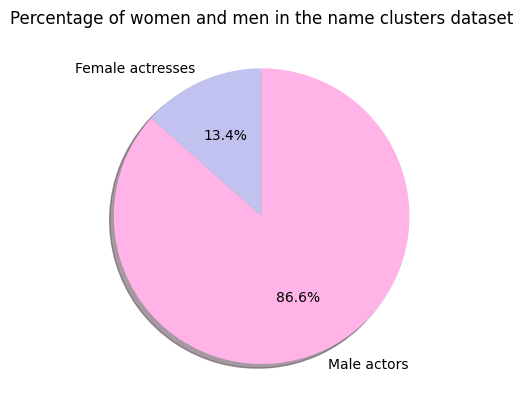

In [65]:

#find number of F and M in name_clusters

x=sum(name_clusters["Actor gender"] == 'F')

y=sum(name_clusters["Actor gender"] == 'M')

#plot in a pie chart x and y

labels = 'Female actresses', 'Male actors'
sizes = [x, y]


fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',colors = ['#c2c2f0','#ffb3e6'],   shadow=True, startangle=90)
ax1.set_title('Percentage of women and men in the name clusters dataset')



















